In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.datasets import cifar10
from keras.wrappers.scikit_learn import KerasClassifier
import talos as ta
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Get the data set
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, x_test.shape, y_train.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1))

([<matplotlib.axis.XTick at 0x1fb41df8668>,
 <a list of 10 Text xticklabel objects>)

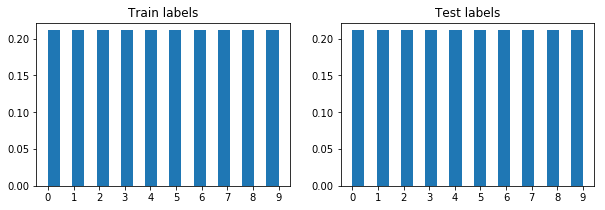

In [3]:
# Check distributions of labels in train and test sets
y_train_df = pd.Series(y_train.reshape(y_train.shape[0]),dtype = 'category')
y_test_df = pd.Series(y_test.reshape(y_test.shape[0]), dtype = 'category')
binboundaries = np.linspace(0,9,20)
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.hist(y_train, bins = binboundaries, density = True)
plt.title('Train labels')
plt.xticks(range(10))

plt.subplot(122)
plt.hist(y_test, bins = binboundaries, density = True)
plt.title('Test labels')
plt.xticks(range(10))

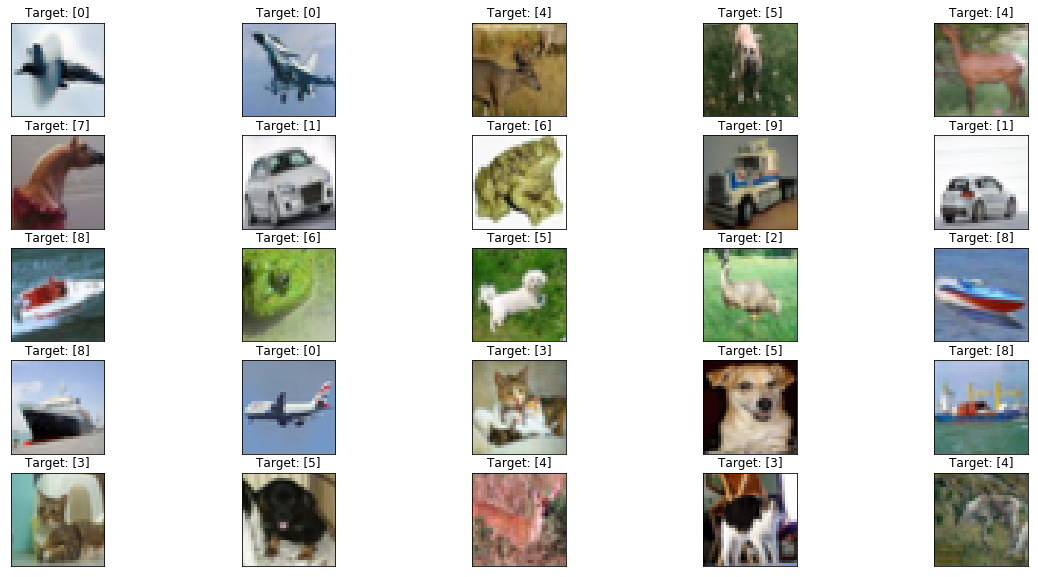

In [49]:
# Create a viusalization function to see the images
def visualize(image, label, ax):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Target: %s'%str(label))
                
fig, axes = plt.subplots(5,5,figsize=(20,10))
for ind1 in range(5):
    for ind2 in range(5):
        loc = np.random.choice(x_train.shape[0])
        image = x_train[loc]
        label = y_train[loc]
        visualize(image, label,axes[ind1,ind2])        

In [5]:
# Trivial preprocessing and normalization
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

#### We will use apply both standard fully connected and convolutional neural network architures. The fully connected architecture by construction considers each pixel value to be independent whereas the convolutional architecture uses spatial information to identify rich features that can be helpful in idenifying intricate correlated patterns.

##### Fully Connected Architecture

In [6]:
def makeModel(input_dim, hunits = [512,256], output = 10, activation = 'relu',
             optimizer = 'Adam', lr= 0.001, momentum = None, init_mode = 'glorot_normal', dropout = False):
    
    network = Sequential()
    layer_sizes = hunits + [output]
    input_tensors = [input_dim] + hunits
    for ind, (val,size) in enumerate(zip(layer_sizes, input_tensors)):
        print(ind, val, size)
        if ind < len(layer_sizes)-1:
            network.add(layers.Dense(val, activation = activation, kernel_initializer = init_mode, input_shape = (size, )))
            if dropout:
                network.add(layers.Dropout(dropout))
        else:
            network.add(layers.Dense(val, activation='softmax'))
    
    if optimizer =='SGD':
        if momentum ==None:
            opt = optimizers.SGD(lr=lr)
        else:
            opt = optimizers.SGD(lr=lr, momentum=momentum, Nesterov = True)
    elif optimizer =='Adam':
        opt = optimizers.Adam(lr=lr)
    elif optimizer =='Nadam':
        opt = optimizers.Nadam(lr=lr)
    elif optimizer =='RMSprop':      
        opt = optimizers.RMSprop(lr=lr)
    elif optimizer =='Adagrad':      
        opt = optimizers.Adagrad(lr=lr)
    else:
        opt = optimizer     
                  
    network.compile(optimizer = opt, loss= 'categorical_crossentropy' , metrics = ['accuracy'])
    return network
makeModel(3072).summary()

0 512 3072
1 256 512
2 10 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Reshaping images to vectors
x_train_fc = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test_fc = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

# One hot encoding of labels to get a probability mass function vector
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train_labels = lb.fit_transform(y_train_df)
y_test_labels = lb.fit_transform(y_test_df)
x_train_fc.shape, x_test_fc.shape, y_train_labels.shape, y_test_labels.shape

((50000, 3072), (10000, 3072), (50000, 10), (10000, 10))

In [8]:
def getStratifiedsets(x,y,ratio):
    split = StratifiedShuffleSplit(n_splits = 1, test_size = ratio, random_state = 42)
    for train_index, val_index in split.split(x, y):
        x_train, x_val = x[train_index], x[val_index]
        y_train_labels, y_val_labels = y[train_index], y[val_index]

    return x_train, x_val, y_train_labels, y_val_labels    

0 1024 3072
1 1024 1024
2 512 1024
3 512 512
4 256 512
5 256 256
6 128 256
7 128 128
8 64 128
9 64 64
10 10 64


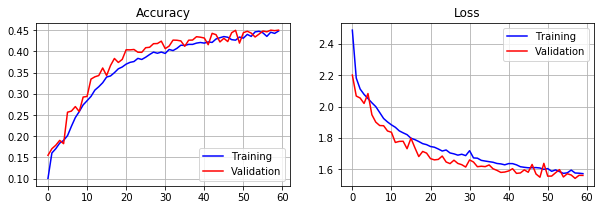

In [9]:
# Sanity check trial run
epochs = 60
model = makeModel(3072, hunits = [1024,1024,512,512,256,256,128,128,64,64], optimizer = 'Adam', activation = 'elu', \
                  dropout = 0.3)

ratio = 0.3
x_train_strat, x_val_strat, y_train_strat, y_val_strat = getStratifiedsets(x_train_fc,y_train_labels,ratio= ratio)
                                                                     
out = model.fit(x_train_strat, y_train_strat, validation_data = (x_val_strat,y_val_strat), epochs = epochs, \
                     batch_size = 128, verbose = 0)
   
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.plot(range(epochs),out.history['acc'], '-b', label ='Training')
plt.plot(range(epochs),out.history['val_acc'], '-r', label = 'Validation')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(122)
plt.plot(range(epochs),out.history['loss'], '-b', label ='Training')
plt.plot(range(epochs),out.history['val_loss'], '-r', label = 'Validation')
plt.title('Loss')
plt.grid()
plt.legend()

In [10]:
# Alter the model function so that we can use talos for hyperparameter tuning

def makeModelNew(x_train, y_train, x_val, y_val, params):
    
    hunits = [1024,1024,512,512,256,256,128,128,64,64]
    output = params['output']
    activation = params['activation']
    optimizer = params['optimizer']
    lr = params['lr']
    init_mode = params['init_mode']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    try:
        dropout_rate = params['dropout']
    except:
        dropout_rate = False
        
    input_dim = x_train.shape[1]
    model = Sequential()
    layer_sizes = hunits + [output]
    input_tensors = [input_dim] + hunits
    for ind, (val,size) in enumerate(zip(layer_sizes, input_tensors)):
#         print(ind, val, size)
        if ind < len(layer_sizes)-1:
            model.add(layers.Dense(val, activation = activation, kernel_initializer = init_mode, input_shape = (size, )))
            if dropout_rate:
                model.add(layers.Dropout(dropout_rate))
        else:
            model.add(layers.Dense(val, activation='softmax'))
    
    if optimizer =='SGD':
        try:
            momentum = params['momentum']
            opt = optimizers.SGD(lr=lr, momentum=momentum, Nesterov = True)
        except:
            momentum = False
            opt = optimizers.SGD(lr=lr)
    elif optimizer =='Adam':
        opt = optimizers.Adam(lr=lr)
    elif optimizer =='Nadam':
        opt = optimizers.Nadam(lr=lr)
    elif optimizer =='RMSprop':      
        opt = optimizers.RMSprop(lr=lr)
    elif optimizer =='Adagrad':      
        opt = optimizers.Adagrad(lr=lr)
    else:
        opt = optimizer     
                  
    model.compile(optimizer = opt, loss= 'categorical_crossentropy' , metrics = ['accuracy'])
    out = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = [x_val, y_val],\
                    verbose = 0)
    
#     print('Parameters\n\n')
#     print('Number of hidden units: {}\n'.format(hunits))
#     print('Activation: {}\n'.format(activation))
#     print('Optimizer: {}\n'.format(optimizer))
#     print('Learning rate: {}\n'.format(lr))
#     print('Initialization: {}\n'.format(init_mode))
#     print('Batch size: {}\n'.format(batch_size))
#     print('Epochs: {}\n'.format(epochs))
#     print('Dropout rate: {}\n'.format(dropout_rate))
#     print('Momentum: {}\n'.format(momentum))
           
    print('Training accuracy: {}'.format(out.history['acc'][-1]))
    print('Validation accuracy: {}'.format(out.history['val_acc'][-1]))
   
    return out, model

##### We will use a randomized search for specific hyper-parameters. Even for few selected parameters the search space is huge. We will limitthe search to 0.01 % of all the possible permutations. For the chosen parameters dictionary below the number of permutations is 128000. We will scan through 12 of those combinations just to see the fucntioning of a fully connected network with hyperparameter tuning.

In [16]:
param_grid = {'lr' : (0,0.1,10),
              'activation': ['elu'],
              'init_mode' : ['glorot_normal'],
              'optimizer': ['Adam', 'SGD'],
              'batch_size' : (32, 512, 32),
              'epochs' : (40,200,20),
              'output' : [10],
              'dropout' : (0,0.4,10),
              'momentum': [0.9]}

ratio = 0.3
x_train_strat, x_val_strat, y_train_strat, y_val_strat = getStratifiedsets(x_train_fc,y_train_labels,ratio=ratio)
datasetname = 'cifar10'
try:
    t = ta.Scan(x_train_strat, y_train_strat, model = makeModelNew, x_val = x_val_strat, y_val = y_val_strat, \
                params = param_grid, print_params = True, dataset_name = datasetname, grid_downsample=.0001)
except:
    pass




  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

{'lr': 0.02, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 107, 'epochs': 72, 'output': 10, 'dropout': 0.16, 'momentum': 0.9}
Training accuracy: 0.556571427316325
Validation accuracy: 0.5205999978462855




  8%|██████▊                                                                           | 1/12 [05:18<58:25, 318.65s/it]

{'lr': 0.08, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 392, 'epochs': 72, 'output': 10, 'dropout': 0.12, 'momentum': 0.9}
Training accuracy: 0.5683142867088318
Validation accuracy: 0.4930666628042857




 17%|█████████████▋                                                                    | 2/12 [08:09<45:43, 274.37s/it]

{'lr': 0.03, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 167, 'epochs': 104, 'output': 10, 'dropout': 0.08, 'momentum': 0.9}
Training accuracy: 0.7028285713587489
Validation accuracy: 0.5465333366711934




 25%|████████████████████▌                                                             | 3/12 [14:28<45:50, 305.63s/it]

{'lr': 0.06, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 242, 'epochs': 56, 'output': 10, 'dropout': 0.36, 'momentum': 0.9}
Training accuracy: 0.4014571401136262
Validation accuracy: 0.4221333316365878




 33%|███████████████████████████▎                                                      | 4/12 [17:10<35:00, 262.61s/it]

{'lr': 0.06, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 92, 'epochs': 152, 'output': 10, 'dropout': 0.12, 'momentum': 0.9}
Training accuracy: 0.9002000123296465
Validation accuracy: 0.5551333264032999




 42%|██████████████████████████████████▏                                               | 5/12 [30:24<49:14, 422.01s/it]

{'lr': 0.09, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 122, 'epochs': 184, 'output': 10, 'dropout': 0.24, 'momentum': 0.9}
Training accuracy: 0.768457143851689
Validation accuracy: 0.5669333274006844




 50%|█████████████████████████████████████████                                         | 6/12 [42:20<51:01, 510.18s/it]

{'lr': 0.02, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 152, 'epochs': 160, 'output': 10, 'dropout': 0.36, 'momentum': 0.9}
Training accuracy: 0.4677714269024985
Validation accuracy: 0.4669333307266235




 58%|███████████████████████████████████████████████▊                                  | 7/12 [52:27<44:56, 539.31s/it]

{'lr': 0.05, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 47, 'epochs': 48, 'output': 10, 'dropout': 0.04, 'momentum': 0.9}
Training accuracy: 0.7918857225026403
Validation accuracy: 0.5188666639486949




 67%|██████████████████████████████████████████████████████▋                           | 8/12 [58:49<32:48, 492.02s/it]

{'lr': 0.06, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 392, 'epochs': 168, 'output': 10, 'dropout': 0.12, 'momentum': 0.9}
Training accuracy: 0.686514287185669
Validation accuracy: 0.5385999925613403




 75%|████████████████████████████████████████████████████████████                    | 9/12 [1:05:29<23:13, 464.49s/it]

{'lr': 0.09, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'Adam', 'batch_size': 197, 'epochs': 96, 'output': 10, 'dropout': 0.24, 'momentum': 0.9}
Training accuracy: 0.10234285684398242
Validation accuracy: 0.10000000007227063




 83%|█████████████████████████████████████████████████████████████████▊             | 10/12 [1:12:16<14:54, 447.28s/it]

{'lr': 0.07, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'SGD', 'batch_size': 227, 'epochs': 96, 'output': 10, 'dropout': 0.32, 'momentum': 0.9}
Training accuracy: 0.49362857335465293
Validation accuracy: 0.4961999991973241




 92%|████████████████████████████████████████████████████████████████████████▍      | 11/12 [1:16:51<06:35, 395.64s/it]

{'lr': 0.09, 'activation': 'elu', 'init_mode': 'glorot_normal', 'optimizer': 'Adam', 'batch_size': 332, 'epochs': 120, 'output': 10, 'dropout': 0.16, 'momentum': 0.9}
Training accuracy: 0.10114285739021642
Validation accuracy: 0.0999999999264876




100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [1:23:02<00:00, 388.16s/it]

Scan Finished!


In [22]:
# Get the best parameters
res = ta.Reporting(datasetname+'_.csv')
res.high()

0.573333332157135

In [31]:
 res.data.sort_values(by = 'val_acc', ascending = False)

,round_epochs,val_loss,val_acc,loss,acc,lr,activation,init_mode,optimizer,batch_size,epochs,output,dropout,momentum
5,184,1.323327,0.573333,0.686749,0.768457,0.09,elu,glorot_normal,SGD,122,184,10,0.24,0.9
2,104,1.299209,0.561733,0.832099,0.702829,0.03,elu,glorot_normal,SGD,167,104,10,0.08,0.9
4,152,1.350647,0.561533,0.291705,0.900200,0.06,elu,glorot_normal,SGD,92,152,10,0.12,0.9
8,168,1.303832,0.557733,0.878022,0.688543,0.06,elu,glorot_normal,SGD,392,168,10,0.12,0.9
7,48,1.395605,0.534600,0.578416,0.791886,0.05,elu,glorot_normal,SGD,47,48,10,0.04,0.9
1,72,1.365481,0.523600,1.213207,0.568314,0.08,elu,glorot_normal,SGD,392,72,10,0.12,0.9
0,72,1.380507,0.520600,1.258888,0.556571,0.02,elu,glorot_normal,SGD,107,72,10,0.16,0.9
10,96,1.436058,0.496200,1.449580,0.493629,0.07,elu,glorot_normal,SGD,227,96,10,0.32,0.9
6,160,1.479978,0.478533,1.499608,0.469571,0.02,elu,glorot_normal,SGD,152,160,10,0.36,0.9
3,56,1.587466,0.426000,1.677164,0.401457,0.06,elu,glorot_normal,SGD,242,56,10,0.36,0.9


While using talos, the best set of parameters can be extracted using the best_params attribute. It lists the 10 best hyper-parameter combinations with the best being at the top. The best combination is judged based on the validation accuracy by default.

In [33]:
res.best_params()

array([['SGD', 122, 'glorot_normal', 0.9, 0.09, 0.24, 10, 'elu', 184, 0],
       ['SGD', 167, 'glorot_normal', 0.9, 0.03, 0.08, 10, 'elu', 104, 1],
       ['SGD', 92, 'glorot_normal', 0.9, 0.06, 0.12, 10, 'elu', 152, 2],
       ['SGD', 392, 'glorot_normal', 0.9, 0.06, 0.12, 10, 'elu', 168, 3],
       ['SGD', 47, 'glorot_normal', 0.9, 0.05, 0.04, 10, 'elu', 48, 4],
       ['SGD', 392, 'glorot_normal', 0.9, 0.08, 0.12, 10, 'elu', 72, 5],
       ['SGD', 107, 'glorot_normal', 0.9, 0.02, 0.16, 10, 'elu', 72, 6],
       ['SGD', 227, 'glorot_normal', 0.9, 0.07, 0.32, 10, 'elu', 96, 7],
       ['SGD', 152, 'glorot_normal', 0.9, 0.02, 0.36, 10, 'elu', 160, 8],
       ['SGD', 242, 'glorot_normal', 0.9, 0.06, 0.36, 10, 'elu', 56, 9]],
      dtype=object)

The next steps are
1. Retrain the model (whole training data) using the best parameters and evaluate on a completely different test set usually using k-fold cross-validation. talos provides the Evaluate functionality to do this.

2. OR use the Predict functionality to inherit the Scan object details including the best model and use to predict on a test set as.

In [34]:
# Evaluating the trained best model on a test set
e = ta.Evaluate(t) # t is the returned Scan object
e.evaluate(x_test_fc, y_test_labels, folds=5, average='macro')

55.98% (+/- 1.03%)


In [56]:
# Predicting using the best model
model_pred = ta.Predict(t) # t is the returned Scan object
pred_labels = model_pred.predict_classes(x_test_fc)
pred_labels

array([3, 8, 8, ..., 5, 7, 7], dtype=int64)

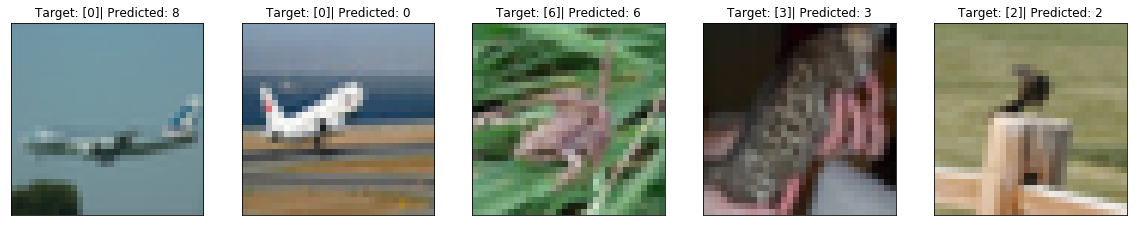

In [59]:
def visualize_pred(image, label, ax, pred_label):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Target: {}| Predicted: {}'.format(str(label), str(pred_label)))
                
fig, axes = plt.subplots(1,5,figsize=(20,5))
axes.shape
for ind in range(5):
    loc = np.random.choice(x_test.shape[0])
    image = x_test[loc]
    label = y_test[loc]
    visualize_pred(image, label, axes[ind], pred_labels[loc])        

#### Convolutional Network Architecture

In [79]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [80]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import collections


def makeConvModel(x_train, y_train, x_val, y_val, params):
    
    activation = params['activation']
    fc_layers = params['fc_layers']
    input_dims = x_train.shape[1:]
    pool = params['pool']
    pool_stride = params['pool_stride']
    filter_stride = params['filter_stride']
    pad = params['pad']
    output = params['output']
    use_batchnorm = params['use_batchnorm']
    optimizer = params['optimizer']
    lr = params['lr']
    filter_dims = params['filter_dims']
    filter_num = params['filter_num']
    conv_layers = len(filter_num)
    regularizer = regularizers.l2(0.01)
    batch_size = params['batch_size']
    epochs = params['epochs']
    seed = params['seed']
    
    try:
        dropout_rate = params['dropout']
    except:
        dropout_rate = False        
         
    model = Sequential()
    
    num_conv = conv_layers
    num_hidd = len(fc_layers)
    f_dims = [0,0]
    # height and width are same
    f_dims[0] = f_dims[1] = filter_dims

    
    if len(filter_num)>1:
        f_nums = filter_num
    else:
        # same filter for all layers
        f_nums = filter_num*num_conv
        
   
    model.add(Conv2D(f_nums[0],(f_dims[0],f_dims[1]), strides = filter_stride, padding = pad, \
                                 input_shape = input_dims, activation = activation, kernel_regularizer = regularizer))
    model.add(MaxPooling2D(pool_size = pool, strides = pool_stride))
        
    if use_batchnorm:
        model.add(BatchNormalization())
    
    print('Conv layer 1')
    print([layer.output_shape for layer in model.layers[-2:]])
    
    for ii in range(num_conv-1):
        model.add(Conv2D(f_nums[ii+1],(f_dims[0],f_dims[1]), strides = filter_stride, padding = pad, \
                                  activation = activation, kernel_regularizer = regularizer))
        model.add(MaxPooling2D(pool_size = pool, strides = pool_stride))
        
        print('Conv layer {}'.format(ii+2))
        print([layer.output_shape for layer in model.layers[-2:]])
        
        if use_batchnorm:
            model.add(BatchNormalization())
    
    model.add(Flatten())
           
    for jj in range(num_hidd):
        units = fc_layers[jj]
        model.add(Dense(units = units, activation = activation, kernel_regularizer = regularizer))
        if dropout_rate:
            model.add(Dropout(dropout_rate, seed = seed))
             
    if output == 2:
        acti = 'sigmoid'
        loss = 'binary_crossentropy'
        units = 1
    elif output > 2:
        acti = 'softmax'
        loss = 'categorical_crossentropy'
        units = output
    
    model.add(Dense(units = units,  activation = acti))
    
     
    if optimizer =='SGD':
        try:
            momentum = params['momentum']
            opt = optimizers.SGD(lr=lr, momentum=momentum, Nesterov = True)
        except:
            momentum = False
            opt = optimizers.SGD(lr=lr)
    elif optimizer =='Adam':
        opt = optimizers.Adam(lr=lr)
    elif optimizer =='Nadam':
        opt = optimizers.Nadam(lr=lr)
    elif optimizer =='RMSprop':      
        opt = optimizers.RMSprop(lr=lr)
    elif optimizer =='Adagrad':      
        opt = optimizers.Adagrad(lr=lr)
    else:
        opt = optimize
    
    model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])
    
    out = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = [x_val, y_val],\
                    verbose = 0)
    
    print('Training accuracy: {}'.format(out.history['acc'][-1]))
    print('Validation accuracy: {}'.format(out.history['val_acc'][-1]))
    
    return out, model

Conv layer 1
[(None, 16, 16, 64), (None, 16, 16, 64)]
Conv layer 2
[(None, 16, 16, 128), (None, 8, 8, 128)]
Conv layer 3
[(None, 8, 8, 256), (None, 4, 4, 256)]
Conv layer 4
[(None, 4, 4, 512), (None, 2, 2, 512)]
Training accuracy: 0.8230285714285714
Validation accuracy: 0.7083999999682109


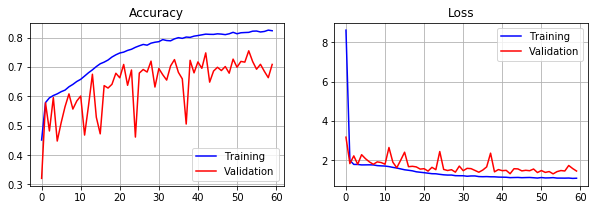

In [86]:
# Sanity check trial run
param_grid = {'lr' : 0.001,
              'activation': 'elu',
              'fc_layers' : [128,256,512],
              'pool' : 2,
              'pool_stride' : 2,
              'filter_stride': 1,
              'pad': 'same',
              'output' : 10,
              'use_batchnorm': True,
              'optimizer':'Adam',
              'filter_dims': 5,
              'filter_num': [64,128,256,512],
              'batch_size': 128,
              'epochs' : 60,
              'seed':10, 
              'dropout' : 0.4
             }

ratio = 0.3
epochs = 60
x_train_strat, x_val_strat, y_train_strat, y_val_strat = getStratifiedsets(x_train,y_train_labels,ratio= ratio)
                                                                     
out,_ = makeConvModel(x_train_strat, y_train_strat, x_val_strat, y_val_strat, params= param_grid)
   
plt.figure(figsize = (10,3))
plt.subplot(121)
plt.plot(range(epochs),out.history['acc'], '-b', label ='Training')
plt.plot(range(epochs),out.history['val_acc'], '-r', label = 'Validation')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(122)
plt.plot(range(epochs),out.history['loss'], '-b', label ='Training')
plt.plot(range(epochs),out.history['val_loss'], '-r', label = 'Validation')
plt.title('Loss')
plt.grid()
plt.legend()